# UniVI CITE-seq data integration demonstration/tutorial - Bipartite matching prior to training test

Andrew Ashford, Pathways + Omics Group, Oregon Health & Science University - 11/18/2025

This Jupyter Notebook will be used to outline the training steps for a UniVI model using human PBMC CITE-seq data. This is a copy of the other version that will be used to test an approach which we artificially "pair" the cells prior to training using a bipartite matching approach, since the model requires paired samples to train. This approach might be able to circumvent the necessity of paired cells between modalities for training a robust integration model.


#### Import modules

In [1]:
import os, sys, json
import numpy as np
import scanpy as sc
import torch


In [2]:
# -------------------------
# 0. Wire up package import
# -------------------------
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from univi import (
    UniVIMultiModalVAE,
    ModalityConfig,
    UniVIConfig,
    TrainingConfig,
    matching,
)
from univi.data import MultiModalDataset
from univi.trainer import UniVITrainer


In [ ]:
import torch
print("Torch:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


#### Read in and preprocess data as needed

In [4]:
# -------------------------
# 1. Load AnnData objects
# -------------------------
# Load RNA AnnData object
rna_adata = sc.read_h5ad("../data/Hao_CITE-seq_data/Hao_RNA_data.h5ad")


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [5]:
# Sanity check
print(rna_adata)
print(rna_adata.X)
print(rna_adata.X.min())
print(rna_adata.X.max())


AnnData object with n_obs × n_vars = 161764 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    obsp: 'distances'
  (0, 1)	0.6931471805599453
  (0, 19)	0.6931471805599453
  (0, 23)	0.6931471805599453
  (0, 28)	0.6931471805599453
  (0, 30)	1.3862943611198906
  (0, 48)	0.6931471805599453
  (0, 49)	1.3862943611198906
  (0, 54)	0.6931471805599453
  (0, 57)	1.0986122886681096
  (0, 63)	0.6931471805599453
  (0, 82)	2.1972245773362196
  (0, 98)	0.6931471805599453
  (0, 99)	0.6931471805599453
  (0, 111)	1.791759469228055
  (0, 127)	0.6931471805599453
  (0, 138)	0.6931471805599453
  (0, 149)	0.6931471805599453
  (0, 151)	1.6094379124341003
  (0, 157)	0.6931471805599453
  (0, 159)	0.6931471805599453
  (0, 160)	0

In [6]:
# Change the RNA counts to raw counts so they're not log-normalized and use ZINB or NB as the decoder distribution
# for model training
rna_adata.layers['log1p'] = rna_adata.X
rna_adata.X = rna_adata.raw.X


In [7]:
# Sanity check
print(rna_adata.X)
print(rna_adata.X.min())
print(rna_adata.X.max())


  (0, 1)	1.0
  (0, 19)	1.0
  (0, 23)	1.0
  (0, 28)	1.0
  (0, 30)	3.0
  (0, 48)	1.0
  (0, 49)	3.0
  (0, 54)	1.0
  (0, 57)	2.0
  (0, 63)	1.0
  (0, 82)	8.0
  (0, 98)	1.0
  (0, 99)	1.0
  (0, 111)	5.0
  (0, 127)	1.0
  (0, 138)	1.0
  (0, 149)	1.0
  (0, 151)	4.0
  (0, 157)	1.0
  (0, 159)	1.0
  (0, 160)	1.0
  (0, 161)	1.0
  (0, 162)	1.0
  (0, 170)	2.0
  (0, 182)	1.0
  :	:
  (161763, 16110)	4.0
  (161763, 16113)	4.0
  (161763, 16130)	1.0
  (161763, 16158)	3.0
  (161763, 16159)	4.0
  (161763, 16160)	8.0
  (161763, 16163)	1.0
  (161763, 16184)	33.0
  (161763, 16185)	34.0
  (161763, 16186)	99.0
  (161763, 16187)	72.0
  (161763, 16188)	1.0
  (161763, 16189)	64.0
  (161763, 16190)	75.0
  (161763, 16191)	53.0
  (161763, 16193)	31.0
  (161763, 16194)	9.0
  (161763, 16196)	51.0
  (161763, 16350)	1.0
  (161763, 16585)	1.0
  (161763, 16688)	1.0
  (161763, 17511)	1.0
  (161763, 17866)	3.0
  (161763, 18249)	1.0
  (161763, 18702)	1.0
0.0
8513.0


In [8]:
# If your counts are in rna_adata.X (raw or log-normalized), this is fine:
sc.pp.highly_variable_genes(
    rna_adata,
    layer='log1p',
    n_top_genes=2000,
    flavor="seurat",   # or "cell_ranger" / "seurat_v3"
    inplace=True,
)


In [9]:
# Boolean mask of HVGs
hvg_mask = rna_adata.var["highly_variable"].values

# Names of the top HVGs
hvg_genes = rna_adata.var_names[hvg_mask].tolist()
print(f"Selected {len(hvg_genes)} highly variable genes.")
print(hvg_genes[:20])  # peek at first few


Selected 2000 highly variable genes.
['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'RBP7', 'EPHA2', 'PADI4', 'CDA', 'EIF4G3', 'AL031005.1', 'C1QA', 'C1QC', 'C1QB', 'TCEA3', 'ID3', 'RCAN3', 'LDLRAP1', 'STMN1', 'ZNF683', 'IFI6']


In [10]:
# Optional: make a HVG-only AnnData for modeling
rna_adata_hvg = rna_adata[:, hvg_mask].copy()
print(rna_adata_hvg)


AnnData object with n_obs × n_vars = 161764 × 2000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'log1p'
    obsp: 'distances'


In [11]:
# Load ADT AnnData object
adt_adata = sc.read_h5ad("../data/Hao_CITE-seq_data/Hao_ADT_data.h5ad")


In [12]:
# Sanity check
print(adt_adata)
print(adt_adata.X)
print(adt_adata.X.min())
print(adt_adata.X.max())


AnnData object with n_obs × n_vars = 161764 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'APCA'
[[1.95916424 0.86914159 1.48523314 ... 0.55307644 1.04608444 1.72565693]
 [0.4322284  1.01422751 0.79594998 ... 0.66587988 0.85514588 1.37971736]
 [0.61381759 1.30390619 0.75610373 ... 0.6874892  0.75610373 1.04246048]
 ...
 [1.50685426 0.54914608 1.0656108  ... 0.25674036 0.25674036 1.16168749]
 [1.63537843 0.32520632 1.19570797 ... 0.45519093 0.51435145 2.10485699]
 [1.58503    0.64458811 1.61118685 ... 0.416905   0.23002318 2.07731277]]
0.0
8.589231339100166


In [13]:
# Set the ADT data to raw counts and use a NB or ZINB decoder in model training and save the current .X counts to
# .layers['log1p']
adt_adata.layers['log1p'] = adt_adata.X
adt_adata.X = adt_adata.raw.X


In [14]:
# Sanity check
print(adt_adata)
print(adt_adata.X)
print(adt_adata.X.min())
print(adt_adata.X.max())


AnnData object with n_obs × n_vars = 161764 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'APCA'
    layers: 'log1p'
  (0, 0)	66.0
  (0, 1)	15.0
  (0, 2)	37.0
  (0, 3)	142.0
  (0, 4)	4.0
  (0, 5)	3.0
  (0, 6)	242.0
  (0, 7)	9.0
  (0, 8)	752.0
  (0, 9)	14.0
  (0, 10)	5.0
  (0, 11)	3.0
  (0, 13)	20.0
  (0, 14)	8.0
  (0, 15)	4.0
  (0, 16)	1.0
  (0, 17)	5.0
  (0, 18)	4.0
  (0, 19)	2.0
  (0, 20)	5.0
  (0, 21)	28.0
  (0, 22)	1.0
  (0, 23)	12.0
  (0, 24)	479.0
  (0, 25)	6.0
  :	:
  (161763, 203)	3.0
  (161763, 204)	2.0
  (161763, 205)	3.0
  (161763, 206)	34.0
  (161763, 207)	149.0
  (161763, 208)	38.0
  (161763, 209)	23.0
  (161763, 210)	79.0
  (161763, 211)	3.0
  (161763, 212)	109.0
  (161763, 213)	13.0
  (161763, 214)	5.0
  (161763, 215)	1.0

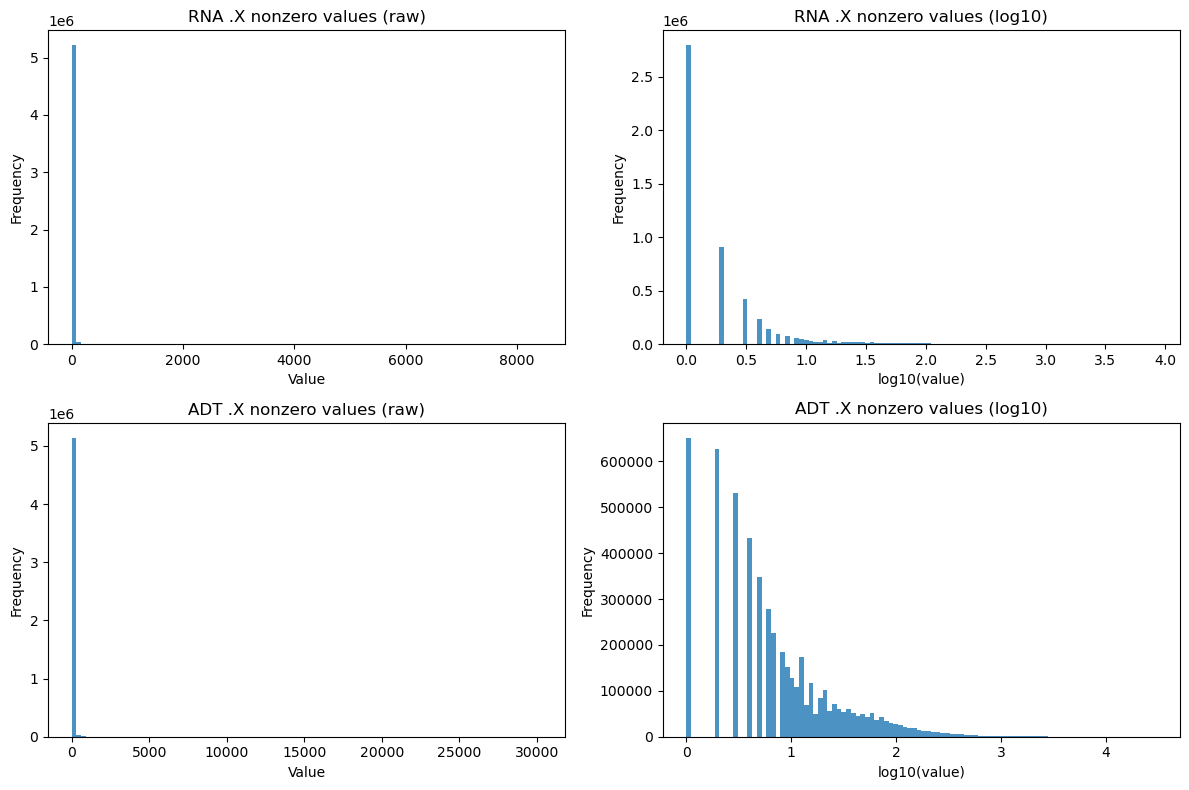

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

def get_X_values(adata, n_cells: int = 5000):
    """
    Return flattened values from adata.X (optionally subsampled over cells).
    Uses only non-zero entries if X is sparse.
    """
    X = adata.X

    # Optional subsampling over cells (rows)
    if n_cells is not None and adata.n_obs > n_cells:
        idx = np.random.choice(adata.n_obs, size=n_cells, replace=False)
        X = X[idx]

    if sparse.issparse(X):
        vals = X.data  # nonzero values
    else:
        vals = np.asarray(X).ravel()

    # Remove zeros explicitly (just to focus on count/ADT magnitude)
    vals = vals[vals > 0]
    return vals

def plot_X_distribution(rna_adata, adt_adata, n_cells: int = 5000):
    rna_vals = get_X_values(rna_adata, n_cells=n_cells)
    adt_vals = get_X_values(adt_adata, n_cells=n_cells)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # --- RNA raw ---
    axes[0, 0].hist(rna_vals, bins=100, alpha=0.8)
    axes[0, 0].set_title("RNA .X nonzero values (raw)")
    axes[0, 0].set_xlabel("Value")
    axes[0, 0].set_ylabel("Frequency")

    # --- RNA log10 ---
    axes[0, 1].hist(np.log10(rna_vals + 1e-8), bins=100, alpha=0.8)
    axes[0, 1].set_title("RNA .X nonzero values (log10)")
    axes[0, 1].set_xlabel("log10(value)")
    axes[0, 1].set_ylabel("Frequency")

    # --- ADT raw ---
    axes[1, 0].hist(adt_vals, bins=100, alpha=0.8)
    axes[1, 0].set_title("ADT .X nonzero values (raw)")
    axes[1, 0].set_xlabel("Value")
    axes[1, 0].set_ylabel("Frequency")

    # --- ADT log10 ---
    axes[1, 1].hist(np.log10(adt_vals + 1e-8), bins=100, alpha=0.8)
    axes[1, 1].set_title("ADT .X nonzero values (log10)")
    axes[1, 1].set_xlabel("log10(value)")
    axes[1, 1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Call it:
plot_X_distribution(rna_adata_hvg, adt_adata, n_cells=25000)


In [16]:
print(rna_adata_hvg)
print(set(rna_adata_hvg.obs['celltype.l1']))
print(rna_adata_hvg.obs['celltype.l1'].value_counts())
print(set(rna_adata_hvg.obs['celltype.l2']))
print(rna_adata_hvg.obs['celltype.l2'].value_counts())
print(set(rna_adata_hvg.obs['celltype.l3']))
print(rna_adata_hvg.obs['celltype.l3'].value_counts())


AnnData object with n_obs × n_vars = 161764 × 2000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'log1p'
    obsp: 'distances'
{'NK', 'other T', 'DC', 'CD4 T', 'CD8 T', 'Mono', 'other', 'B'}
Mono       49010
CD4 T      41001
CD8 T      25469
NK         18664
B          13800
other T     6789
DC          3589
other       3442
Name: celltype.l1, dtype: int64
{'Treg', 'gdT', 'Eryth', 'NK_CD56bright', 'CD14 Mono', 'CD8 Naive', 'CD4 Proliferating', 'CD8 Proliferating', 'Doublet', 'cDC2', 'B intermediate', 'HSPC', 'ILC', 'CD4 TCM', 'CD4 TEM', 'ASDC', 'CD4 CTL', 'CD16 Mono', 'CD8 TCM', 'Plasmablast', 'NK', 'CD8 TEM', 'MAIT', 'cDC1', '

#### Initialize model and data via dataloaders

In [17]:
import json
from univi.config import ModalityConfig, UniVIConfig, TrainingConfig

# -------------------------
# 1. Load JSON
# -------------------------
with open("../parameter_files/defaults_cite_seq_raw_counts.json") as f:
    cfg_json = json.load(f)

data_cfg  = cfg_json["data"]
model_cfg = cfg_json["model"]
train_cfg_json = cfg_json["training"]

# -------------------------
# 2. Build ModalityConfig list
# -------------------------
adata_by_mod = {
    "rna": rna_adata_hvg,   # make sure these exist
    "adt": adt_adata,
}

modality_cfgs = []
for m in data_cfg["modalities"]:
    name = m["name"]
    if name not in adata_by_mod:
        raise ValueError(f"Modality '{name}' not found in adata_by_mod")

    adata = adata_by_mod[name]
    hidden = m.get("hidden_dims", model_cfg["hidden_dims_default"])

    mc = ModalityConfig(
        name=name,
        input_dim=int(adata.n_vars),
        encoder_hidden=hidden,
        decoder_hidden=hidden,
        likelihood=m["likelihood"],   # "nb", "gaussian", "zinb", etc.
    )
    modality_cfgs.append(mc)

print("Built ModalityConfig list:")
for mc in modality_cfgs:
    print(" ", mc)

assert len(modality_cfgs) > 0, "No modalities found for UniVIConfig!"

# -------------------------
# 3. UniVIConfig
# -------------------------
univi_cfg = UniVIConfig(
    latent_dim=model_cfg["latent_dim"],
    modalities=modality_cfgs,
    beta=model_cfg["beta"],
    gamma=model_cfg["gamma"],
    encoder_dropout=model_cfg.get("dropout", 0.0),
    encoder_batchnorm=model_cfg.get("batchnorm", True),
    #kl_anneal_start=model_cfg.get("kl_anneal_start", 0),
    kl_anneal_start=0,
    #kl_anneal_end=model_cfg.get("kl_anneal_end", 0),\
    kl_anneal_end=25,
    #align_anneal_start=model_cfg.get("align_anneal_start", 0),
    align_anneal_start=0,
    #align_anneal_end=model_cfg.get("align_anneal_end", 0),
    align_anneal_end=25,
)

print("UniVIConfig:", univi_cfg)

# -------------------------
# 4. TrainingConfig
# -------------------------
train_cfg = TrainingConfig(
    n_epochs=train_cfg_json["n_epochs"],
    batch_size=train_cfg_json["batch_size"],
    lr=train_cfg_json["lr"],
    weight_decay=train_cfg_json.get("weight_decay", 0.0),
    device=train_cfg_json.get("device", "cpu"),  # use "cpu" if no CUDA
    log_every=train_cfg_json.get("log_every", 10),
    grad_clip=train_cfg_json.get("grad_clip", None),
    num_workers=train_cfg_json.get("num_workers", 0),
    seed=train_cfg_json.get("seed", 0),
    early_stopping=train_cfg_json.get("early_stopping", True),
    patience=train_cfg_json.get("patience", 20),
    min_delta=train_cfg_json.get("min_delta", 0.0),
)

print("TrainingConfig:", train_cfg)


Built ModalityConfig list:
  ModalityConfig(name='rna', input_dim=2000, encoder_hidden=[512, 256], decoder_hidden=[512, 256], likelihood='nb')
  ModalityConfig(name='adt', input_dim=228, encoder_hidden=[128, 64], decoder_hidden=[128, 64], likelihood='nb')
UniVIConfig: UniVIConfig(latent_dim=40, modalities=[ModalityConfig(name='rna', input_dim=2000, encoder_hidden=[512, 256], decoder_hidden=[512, 256], likelihood='nb'), ModalityConfig(name='adt', input_dim=228, encoder_hidden=[128, 64], decoder_hidden=[128, 64], likelihood='nb')], beta=80.0, gamma=120.0, encoder_dropout=0.1, decoder_dropout=0.0, encoder_batchnorm=True, decoder_batchnorm=False, kl_anneal_start=0, kl_anneal_end=25, align_anneal_start=0, align_anneal_end=25)
TrainingConfig: TrainingConfig(n_epochs=500, batch_size=256, lr=0.001, weight_decay=0.0001, device='cpu', log_every=10, grad_clip=5.0, num_workers=0, seed=42, early_stopping=True, patience=20, min_delta=0.0)


In [18]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.cross_decomposition import CCA

from univi.data import MultiModalDataset
from univi.matching import bipartite_match_adata

# --------------------------------------------------
# 0. Sanity check: RNA / ADT are aligned (Hao)
# --------------------------------------------------
assert rna_adata_hvg.n_obs == adt_adata.n_obs, "RNA and ADT have different #cells"
assert np.array_equal(rna_adata_hvg.obs_names, adt_adata.obs_names), (
    "RNA and ADT obs_names are not aligned – align them first."
)

N = rna_adata_hvg.n_obs
print(f"Total cells in Hao CITE-seq (paired): {N}")


Total cells in Hao CITE-seq (paired): 161764


In [19]:
# --------------------------------------------------
# 0.5 Learn / use a shared latent space ("X_shared")
#     using CCA on the true pairs (PCA → CCA)
# --------------------------------------------------
assert "X_pca" in rna_adata_hvg.obsm, "rna_adata.obsm['X_pca'] missing"
assert "X_pca" in adt_adata.obsm, "adt_adata.obsm['X_pca'] missing"

if ("X_shared" not in rna_adata_hvg.obsm) or ("X_shared" not in adt_adata.obsm):
    X_rna = np.asarray(rna_adata_hvg.obsm["X_pca"])
    X_adt = np.asarray(adt_adata.obsm["X_pca"])

    n_components = min(60, X_rna.shape[1], X_adt.shape[1])
    print(f"Fitting CCA with n_components={n_components} on Hao pairs...")

    cca = CCA(n_components=n_components, max_iter=2000, scale=False)
    Z_rna, Z_adt = cca.fit_transform(X_rna, X_adt)

    rna_adata_hvg.obsm["X_shared"] = Z_rna.astype(np.float32)
    adt_adata.obsm["X_shared"] = Z_adt.astype(np.float32)

    print("Stored shared latent embedding as 'X_shared' in both adatas.")
else:
    print("Using existing 'X_shared' embedding in rna_adata / adt_adata.")

emb_key = "X_shared"


Fitting CCA with n_components=50 on Hao pairs...
Stored shared latent embedding as 'X_shared' in both adatas.


In [20]:
# --------------------------------------------------
# 1. Make two *unpaired* views by permuting indices
#    (simulate two independent experiments)
# --------------------------------------------------
rng = np.random.default_rng(train_cfg.seed)

idx_rna_view = rng.permutation(N)
idx_adt_view = rng.permutation(N)

rna_view = rna_adata_hvg[idx_rna_view].copy()
adt_view = adt_adata[idx_adt_view].copy()

print("Built unpaired views: rna_view and adt_view")

assert emb_key in rna_view.obsm, f"{emb_key} not found in rna_view.obsm"
assert emb_key in adt_view.obsm, f"{emb_key} not found in adt_view.obsm"


Built unpaired views: rna_view and adt_view


In [21]:
# --------------------------------------------------
# 2. Cell-type–stratified bipartite matching in shared space
# --------------------------------------------------
celltype_key = "celltype.l2"
assert celltype_key in rna_view.obs.columns, f"{celltype_key} not in rna_view.obs"
assert celltype_key in adt_view.obs.columns, f"{celltype_key} not in adt_view.obs"

labels_rna_view = rna_view.obs[celltype_key].astype(str).values
labels_adt_view = adt_view.obs[celltype_key].astype(str).values

unique_ct = np.unique(labels_rna_view)
print(f"Cell types found in rna_view: {unique_ct}")

all_match_rna_view = []
all_match_adt_view = []
ct_match_counts = {}

for ct in unique_ct:
    idx_rna_ct = np.where(labels_rna_view == ct)[0]
    idx_adt_ct = np.where(labels_adt_view == ct)[0]

    if (len(idx_rna_ct) == 0) or (len(idx_adt_ct) == 0):
        print(f"Skipping cell type '{ct}' (rna={len(idx_rna_ct)}, adt={len(idx_adt_ct)})")
        continue

    rna_ct_view = rna_view[idx_rna_ct].copy()
    adt_ct_view = adt_view[idx_adt_ct].copy()

    m_rna_local, m_adt_local = bipartite_match_adata(
        adata_A=rna_ct_view,
        adata_B=adt_ct_view,
        emb_key=emb_key,
        metric="euclidean",
        max_cells=20000,            # per-CT cap; tune as needed
        random_state=train_cfg.seed,
    )

    if len(m_rna_local) == 0:
        print(f"No matches returned for cell type '{ct}' – skipping")
        continue

    # Map back to indices in rna_view / adt_view
    m_rna_view = idx_rna_ct[m_rna_local]
    m_adt_view = idx_adt_ct[m_adt_local]

    all_match_rna_view.append(m_rna_view)
    all_match_adt_view.append(m_adt_view)
    ct_match_counts[ct] = len(m_rna_view)

if len(all_match_rna_view) == 0:
    raise RuntimeError("No matches found for any cell type.")

matched_rna_view_idx = np.concatenate(all_match_rna_view)
matched_adt_view_idx = np.concatenate(all_match_adt_view)

# Shuffle pairs jointly so CT blocks don't remain ordered
perm_pairs = rng.permutation(len(matched_rna_view_idx))
matched_rna_view_idx = matched_rna_view_idx[perm_pairs]
matched_adt_view_idx = matched_adt_view_idx[perm_pairs]

n_matched = len(matched_rna_view_idx)
print(f"Matched {n_matched} pseudo-pairs via celltype-stratified bipartite matching in '{emb_key}' space")
print("Per-celltype match counts:", ct_match_counts)

# Map matched view indices -> original global indices
global_rna_idx = idx_rna_view[matched_rna_view_idx]
global_adt_idx = idx_adt_view[matched_adt_view_idx]


Cell types found in rna_view: ['ASDC' 'B intermediate' 'B memory' 'B naive' 'CD14 Mono' 'CD16 Mono'
 'CD4 CTL' 'CD4 Naive' 'CD4 Proliferating' 'CD4 TCM' 'CD4 TEM' 'CD8 Naive'
 'CD8 Proliferating' 'CD8 TCM' 'CD8 TEM' 'Doublet' 'Eryth' 'HSPC' 'ILC'
 'MAIT' 'NK' 'NK Proliferating' 'NK_CD56bright' 'Plasmablast' 'Platelet'
 'Treg' 'cDC1' 'cDC2' 'dnT' 'gdT' 'pDC']
Matched 139074 pseudo-pairs via celltype-stratified bipartite matching in 'X_shared' space
Per-celltype match counts: {'ASDC': 76, 'B intermediate': 2431, 'B memory': 3285, 'B naive': 7718, 'CD14 Mono': 20000, 'CD16 Mono': 6320, 'CD4 CTL': 1736, 'CD4 Naive': 17479, 'CD4 Proliferating': 108, 'CD4 TCM': 14889, 'CD4 TEM': 4282, 'CD8 Naive': 10768, 'CD8 Proliferating': 91, 'CD8 TCM': 2883, 'CD8 TEM': 11727, 'Doublet': 605, 'Eryth': 83, 'HSPC': 329, 'ILC': 132, 'MAIT': 2784, 'NK': 17173, 'NK Proliferating': 548, 'NK_CD56bright': 943, 'Plasmablast': 366, 'Platelet': 2293, 'Treg': 2507, 'cDC1': 151, 'cDC2': 2501, 'dnT': 356, 'gdT': 3649, 

In [22]:
# --------------------------------------------------
# 3. Evaluate matching quality (identity accuracy)
#    This is possible only because Hao is originally paired.
# --------------------------------------------------
is_true_pair = (global_rna_idx == global_adt_idx)
match_identity_acc = is_true_pair.mean()
print(f"Bipartite matching identity accuracy (true same-cell): {match_identity_acc:.4f}")


Bipartite matching identity accuracy (true same-cell): 0.9235


In [23]:
# --------------------------------------------------
# 4. Build *matched* AnnData objects for training
#    (rows i in rna_matched and adt_matched are pseudo-pairs)
# --------------------------------------------------
rna_matched = rna_adata_hvg[global_rna_idx].copy()
adt_matched = adt_adata[global_adt_idx].copy()

print(f"rna_matched: {rna_matched.n_obs} cells, adt_matched: {adt_matched.n_obs} cells")


rna_matched: 139074 cells, adt_matched: 139074 cells


In [24]:
# --------------------------------------------------
# 5. Optional: per-celltype cap for *matched* dataset (on RNA labels)
# --------------------------------------------------
labels_matched = rna_matched.obs[celltype_key].astype(str).values
unique_ct_matched = np.unique(labels_matched)

max_per_type = 1000
rng = np.random.default_rng(train_cfg.seed)

selected_indices_list = []
for ct in unique_ct_matched:
    idx_ct = np.where(labels_matched == ct)[0]  # indices into rna_matched / adt_matched
    if len(idx_ct) == 0:
        continue
    if len(idx_ct) > max_per_type:
        chosen = rng.choice(idx_ct, size=max_per_type, replace=False)
    else:
        chosen = idx_ct
    selected_indices_list.append(chosen)

selected_indices = np.concatenate(selected_indices_list)
rng.shuffle(selected_indices)

n_cells = len(selected_indices)
print(f"Total matched cells AFTER per-celltype cap: {n_cells}")

rna_trainval = rna_matched[selected_indices].copy()
adt_trainval = adt_matched[selected_indices].copy()

# For book-keeping: global indices corresponding to those capped pairs
global_rna_idx_cap = global_rna_idx[selected_indices]
global_adt_idx_cap = global_adt_idx[selected_indices]


Total matched cells AFTER per-celltype cap: 22649


In [25]:
# --------------------------------------------------
# 6. Build MultiModalDataset from the capped, matched AnnDatas
#    (give synthetic shared obs_names so UniVI sees paired rows)
# --------------------------------------------------
pair_ids = np.array([f"pair_{i:06d}" for i in range(n_cells)], dtype=object)

rna_trainval = rna_trainval.copy()
adt_trainval = adt_trainval.copy()
rna_trainval.obs_names = pair_ids
adt_trainval.obs_names = pair_ids

adata_by_mod_trainval = {"rna": rna_trainval, "adt": adt_trainval}

full_dataset = MultiModalDataset(
    adata_dict=adata_by_mod_trainval,
    X_key="X",                # or your chosen layer/key
    device=train_cfg.device,  # "cpu" or "cuda"
)


In [26]:
# --------------------------------------------------
# 7. Train / val / test split on the *matched* capped cells
# --------------------------------------------------
indices = np.arange(n_cells)
rng = np.random.default_rng(train_cfg.seed)
rng.shuffle(indices)

frac_train = 0.8
frac_val   = 0.1

n_train = int(frac_train * n_cells)
n_val   = int(frac_val   * n_cells)

train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train + n_val]
test_idx  = indices[n_train + n_val:]

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=True,
    num_workers=train_cfg.num_workers,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)


Train: 18119, Val: 2264, Test: 2266


In [27]:
# --------------------------------------------------
# 8. Mark splits in the *original* AnnData objects
#    and define unused cells
# --------------------------------------------------
def init_split_column(adata, col="univi_split"):
    if col not in adata.obs.columns:
        adata.obs[col] = "unused"
    else:
        # reset to "unused" in case it already existed
        adata.obs[col] = "unused"

init_split_column(rna_adata_hvg, "univi_split")
init_split_column(adt_adata, "univi_split")

# translate train/val/test indices (in matched-cap space)
# back to *global positional* indices in the original Hao objects
rna_train_global = global_rna_idx_cap[train_idx]
rna_val_global   = global_rna_idx_cap[val_idx]
rna_test_global  = global_rna_idx_cap[test_idx]

adt_train_global = global_adt_idx_cap[train_idx]
adt_val_global   = global_adt_idx_cap[val_idx]
adt_test_global  = global_adt_idx_cap[test_idx]

# convert positional indices → cell IDs (obs_names)
rna_train_cells = rna_adata_hvg.obs_names[rna_train_global]
rna_val_cells   = rna_adata_hvg.obs_names[rna_val_global]
rna_test_cells  = rna_adata_hvg.obs_names[rna_test_global]

adt_train_cells = adt_adata.obs_names[adt_train_global]
adt_val_cells   = adt_adata.obs_names[adt_val_global]
adt_test_cells  = adt_adata.obs_names[adt_test_global]

# mark splits using labels (safe with .loc)
rna_adata_hvg.obs.loc[rna_train_cells, "univi_split"] = "train"
rna_adata_hvg.obs.loc[rna_val_cells,   "univi_split"] = "val"
rna_adata_hvg.obs.loc[rna_test_cells,  "univi_split"] = "test"

adt_adata.obs.loc[adt_train_cells, "univi_split"] = "train"
adt_adata.obs.loc[adt_val_cells,   "univi_split"] = "val"
adt_adata.obs.loc[adt_test_cells,  "univi_split"] = "test"

# anything not in global_*_idx_cap was never used in the matched+cap set
# → explicit "unused" AnnDatas (never seen by UniVI training/val/test)

rna_used_mask = np.zeros(rna_adata_hvg.n_obs, dtype=bool)
rna_used_mask[global_rna_idx_cap] = True
rna_unused = rna_adata_hvg[~rna_used_mask].copy()

adt_used_mask = np.zeros(adt_adata.n_obs, dtype=bool)
adt_used_mask[global_adt_idx_cap] = True
adt_unused = adt_adata[~adt_used_mask].copy()

print(
    "RNA split sizes:",
    {
        "train":  int((rna_adata_hvg.obs["univi_split"] == "train").sum()),
        "val":    int((rna_adata_hvg.obs["univi_split"] == "val").sum()),
        "test":   int((rna_adata_hvg.obs["univi_split"] == "test").sum()),
        "unused": int(rna_unused.n_obs),
    },
)

print(
    "ADT split sizes:",
    {
        "train":  int((adt_adata.obs["univi_split"] == "train").sum()),
        "val":    int((adt_adata.obs["univi_split"] == "val").sum()),
        "test":   int((adt_adata.obs["univi_split"] == "test").sum()),
        "unused": int(adt_unused.n_obs),
    },
)


RNA split sizes: {'train': 18119, 'val': 2264, 'test': 2266, 'unused': 139115}
ADT split sizes: {'train': 18119, 'val': 2264, 'test': 2266, 'unused': 139115}


In [28]:
import numpy as np

# --------------------------------------------------
# 9. Build split-specific AnnData views
# --------------------------------------------------

def make_splits(adata, split_col="univi_split"):
    """Return train/val/test/unused AnnData views based on a split column."""
    train = adata[adata.obs[split_col] == "train"].copy()
    val   = adata[adata.obs[split_col] == "val"].copy()
    test  = adata[adata.obs[split_col] == "test"].copy()
    unused = adata[adata.obs[split_col] == "unused"].copy()
    return train, val, test, unused

# RNA splits (from rna_adata_hvg)
rna_train_adata, rna_val_adata, rna_test_adata, rna_unused_global = make_splits(
    rna_adata_hvg, split_col="univi_split"
)

# ADT splits (from adt_adata)
adt_train_adata, adt_val_adata, adt_test_adata, adt_unused_global = make_splits(
    adt_adata, split_col="univi_split"
)

print("RNA split AnnData shapes:")
print("  train:", rna_train_adata.n_obs)
print("  val  :", rna_val_adata.n_obs)
print("  test :", rna_test_adata.n_obs)
print("  unused (global):", rna_unused_global.n_obs)

print("ADT split AnnData shapes:")
print("  train:", adt_train_adata.n_obs)
print("  val  :", adt_val_adata.n_obs)
print("  test :", adt_test_adata.n_obs)
print("  unused (global):", adt_unused_global.n_obs)


RNA split AnnData shapes:
  train: 18119
  val  : 2264
  test : 2266
  unused (global): 139115
ADT split AnnData shapes:
  train: 18119
  val  : 2264
  test : 2266
  unused (global): 139115


In [29]:
print("Modalities in univi_cfg:")
for m in univi_cfg.modalities:
    print(" ", m)

print("Number of modalities:", len(univi_cfg.modalities))


Modalities in univi_cfg:
  ModalityConfig(name='rna', input_dim=2000, encoder_hidden=[512, 256], decoder_hidden=[512, 256], likelihood='nb')
  ModalityConfig(name='adt', input_dim=228, encoder_hidden=[128, 64], decoder_hidden=[128, 64], likelihood='nb')
Number of modalities: 2


In [30]:
# -------------------------
# 7. Instantiate model + trainer
# -------------------------
model = UniVIMultiModalVAE(univi_cfg).to(train_cfg.device)

trainer = UniVITrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_cfg=train_cfg,
    device=train_cfg.device,
)


[2025-11-18 17:53:53,832] [UniVITrainer] [INFO] TrainingConfig:
[2025-11-18 17:53:53,835] [UniVITrainer] [INFO]   n_epochs: 500
[2025-11-18 17:53:53,837] [UniVITrainer] [INFO]   batch_size: 256
[2025-11-18 17:53:53,838] [UniVITrainer] [INFO]   lr: 0.001
[2025-11-18 17:53:53,840] [UniVITrainer] [INFO]   weight_decay: 0.0001
[2025-11-18 17:53:53,842] [UniVITrainer] [INFO]   device: cpu
[2025-11-18 17:53:53,845] [UniVITrainer] [INFO]   log_every: 10
[2025-11-18 17:53:53,846] [UniVITrainer] [INFO]   grad_clip: 5.0
[2025-11-18 17:53:53,847] [UniVITrainer] [INFO]   num_workers: 0
[2025-11-18 17:53:53,849] [UniVITrainer] [INFO]   seed: 42
[2025-11-18 17:53:53,850] [UniVITrainer] [INFO]   early_stopping: True
[2025-11-18 17:53:53,852] [UniVITrainer] [INFO]   patience: 20
[2025-11-18 17:53:53,853] [UniVITrainer] [INFO]   min_delta: 0.0


#### Train model

In [31]:
# -------------------------
# 8. Train!
# -------------------------
history = trainer.fit()


Training UniVI:   0%|          | 0/500 [00:00<?, ?it/s]

[2025-11-18 18:02:13,969] [UniVITrainer] [INFO] [Epoch 001] Train loss: 3063.8477 (beta=3.200, gamma=4.800)
[2025-11-18 18:02:37,565] [UniVITrainer] [INFO] [Epoch 001] Val loss: 1625.3486 (beta=3.200, gamma=4.800)
[2025-11-18 18:02:37,706] [UniVITrainer] [INFO] [Epoch 001] New best val loss: 1625.3486
[2025-11-18 18:14:15,657] [UniVITrainer] [INFO] [Epoch 002] New best val loss: 1551.4630
[2025-11-18 18:25:18,079] [UniVITrainer] [INFO] [Epoch 003] New best val loss: 1522.9083
[2025-11-18 18:35:59,581] [UniVITrainer] [INFO] [Epoch 004] New best val loss: 1489.7572
[2025-11-18 18:46:27,431] [UniVITrainer] [INFO] [Epoch 005] New best val loss: 1467.4280
[2025-11-18 18:56:36,125] [UniVITrainer] [INFO] [Epoch 006] New best val loss: 1459.5932
[2025-11-18 19:05:47,115] [UniVITrainer] [INFO] [Epoch 007] New best val loss: 1457.8945
[2025-11-18 19:38:22,199] [UniVITrainer] [INFO] [Epoch 010] Train loss: 1460.6554 (beta=32.000, gamma=48.000)
[2025-11-18 19:38:45,723] [UniVITrainer] [INFO] [Epoc

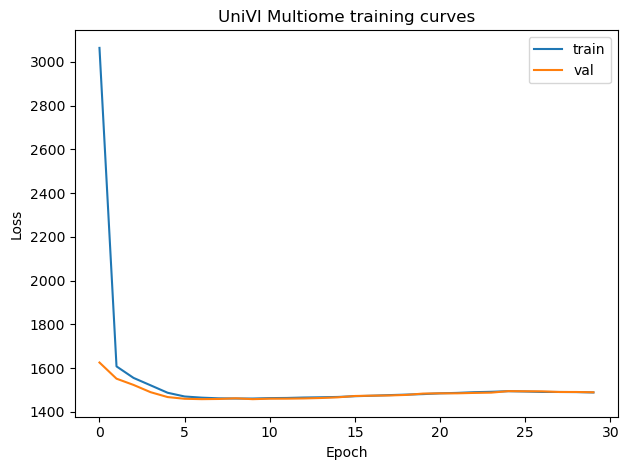

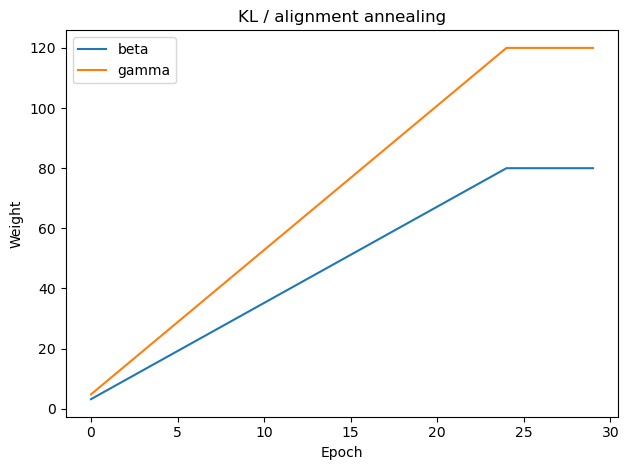

In [46]:
# Quick training curves
fig, ax = plt.subplots()
ax.plot(history["train_loss"], label="train")
ax.plot(history["val_loss"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("UniVI Multiome training curves")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(history["beta"], label="beta")
ax.plot(history["gamma"], label="gamma")
ax.set_xlabel("Epoch")
ax.set_ylabel("Weight")
ax.set_title("KL / alignment annealing")
ax.legend()
plt.tight_layout()
plt.show()


In [32]:
from dataclasses import asdict

os.makedirs("../saved_models", exist_ok=True)

# after training
#history = trainer.fit()

# trainer.model already has the best weights (because we restored best_state_dict)
ckpt_path = "../saved_models/univi_hao_level2_celltype_1k_cap_bipartite_training.pt"
torch.save(
    {
        "state_dict": trainer.model.state_dict(),
        "univi_cfg": asdict(univi_cfg),
        "best_epoch": trainer.best_epoch,
        "best_val_loss": trainer.best_val_loss,
    },
    ckpt_path,
)
print("Saved best model to:", ckpt_path)


Saved best model to: ../saved_models/univi_hao_level2_celltype_1k_cap_bipartite_training.pt


#### Evaluate model

In [33]:
# Later to reload model
import torch
from univi.config import UniVIConfig, ModalityConfig
from univi.models.univi import UniVIMultiModalVAE

device = "cpu"  # or "cuda" if available

ckpt = torch.load(
    "../saved_models/univi_hao_level2_celltype_1k_cap_bipartite_training.pt",
    map_location=device,
)

# ---- Rebuild UniVIConfig, making sure modalities are ModalityConfig objects ----
cfg_dict = ckpt["univi_cfg"]

# If this is an OmegaConf object or similar, make sure it's a plain dict
try:
    from omegaconf import DictConfig, OmegaConf
    if isinstance(cfg_dict, DictConfig):
        cfg_dict = OmegaConf.to_container(cfg_dict, resolve=True)
except ImportError:
    pass

# Now rehydrate each modality
modalities = [ModalityConfig(**m) for m in cfg_dict["modalities"]]
cfg_dict = {**cfg_dict, "modalities": modalities}

univi_cfg_loaded = UniVIConfig(**cfg_dict)

# ---- Rebuild model + load weights ----
model_loaded = UniVIMultiModalVAE(univi_cfg_loaded).to(device)
model_loaded.load_state_dict(ckpt["state_dict"])

print("Best epoch was:", ckpt.get("best_epoch"), "val loss =", ckpt.get("best_val_loss"))


Best epoch was: 10 val loss = 1457.8354085286458


FOSCTTM (rna vs adt): 0.4441
Modality mixing score (k=20): 0.249
Label transfer accuracy (ADT → RNA, k=15): 0.458


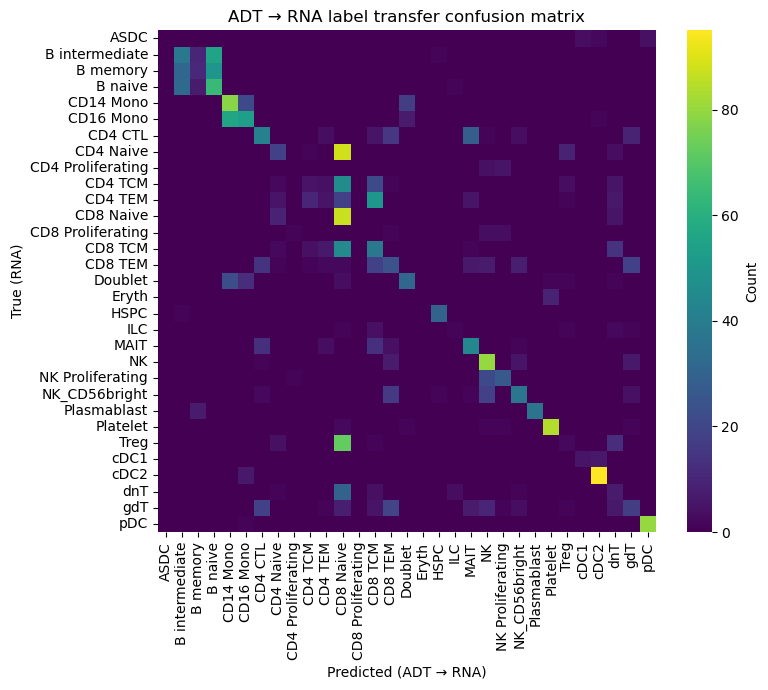

/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/

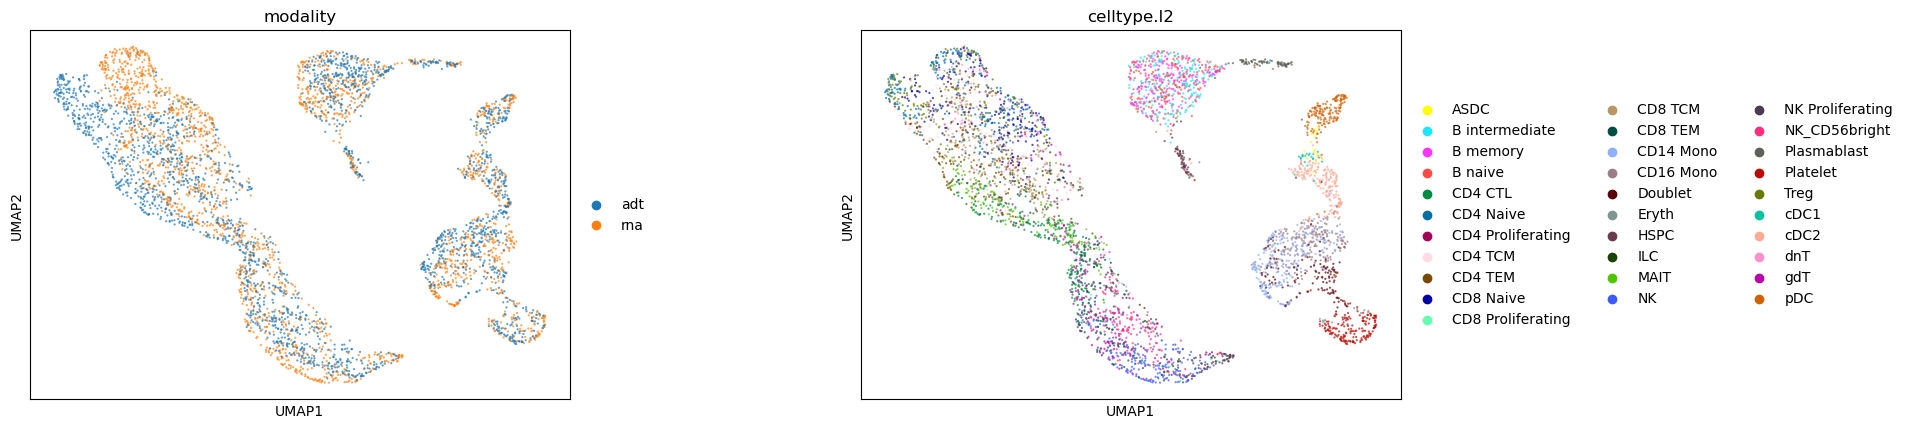

Mean ADT MSE (RNA→ADT): 16713.5303
Mean ADT Pearson r (RNA→ADT): 0.034


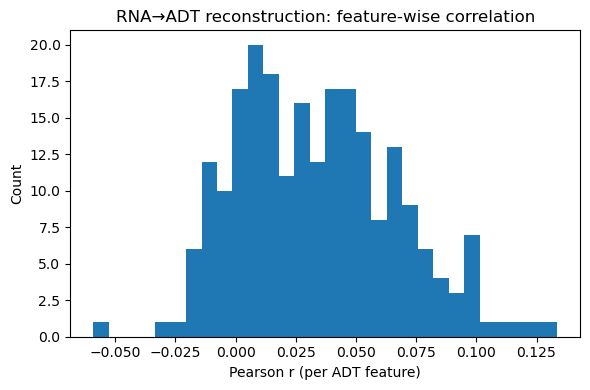

In [34]:
import numpy as np
import torch
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from univi import evaluation as univi_eval
# from univi import plotting as univi_plot  # optional, but not required for showing

# -------------------------
# 1. Encode latent embeddings
# -------------------------
z_rna = trainer.encode_modality(rna_test_adata, modality="rna")
z_adt = trainer.encode_modality(adt_test_adata, modality="adt")

rna_test_adata.obsm["X_univi"] = z_rna
adt_test_adata.obsm["X_univi"] = z_adt

# -------------------------
# 2. FOSCTTM (global alignment)
# -------------------------
foscttm = univi_eval.compute_foscttm(z_rna, z_adt)
print(f"FOSCTTM (rna vs adt): {foscttm:.4f}")

# -------------------------
# 3. Modality mixing in joint embedding
# -------------------------
Z_joint = np.concatenate([z_rna, z_adt], axis=0)
modality_labels = np.array(
    ["rna"] * z_rna.shape[0] + ["adt"] * z_adt.shape[0]
)

mixing_score = univi_eval.compute_modality_mixing(
    Z_joint,
    modality_labels,
    k=20,
)
print(f"Modality mixing score (k=20): {mixing_score:.3f}")

# -------------------------
# 4. Label transfer (ADT → RNA)
# -------------------------
labels_rna = rna_test_adata.obs["celltype.l2"].astype(str).values
labels_adt = adt_test_adata.obs["celltype.l2"].astype(str).values

pred_rna_from_adt, acc_rna, cm_rna = univi_eval.label_transfer_knn(
    Z_source=z_adt,
    labels_source=labels_adt,
    Z_target=z_rna,
    labels_target=labels_rna,
    k=15,
)

print(f"Label transfer accuracy (ADT → RNA, k=15): {acc_rna:.3f}")

# -------------------------
# 4a. Confusion matrix plot (show)
# -------------------------
uniq_labels = np.unique(labels_rna)

plt.figure(figsize=(8, 7))
sns.heatmap(
    cm_rna,
    annot=False,
    cmap="viridis",
    xticklabels=uniq_labels,
    yticklabels=uniq_labels,
    cbar_kws={"label": "Count"},
)
plt.xlabel("Predicted (ADT → RNA)")
plt.ylabel("True (RNA)")
plt.title("ADT → RNA label transfer confusion matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# If you still want a saved PNG version:
# from univi import plotting as univi_plot
# univi_plot.plot_confusion_matrix(
#     cm_rna,
#     labels=uniq_labels,
#     title="ADT → RNA label transfer",
#     savepath="../figures/citeseq_univi_label_transfer_cm_bipartite_training_l2_celltype_1k_cap.png",
# )

# -------------------------
# 5. UMAP visualization on UniVI latent
# -------------------------

# Make copies and add modality labels
rna_tmp = rna_test_adata.copy()
adt_tmp = adt_test_adata.copy()

rna_tmp.obs["modality"] = "rna"
adt_tmp.obs["modality"] = "adt"

# Concatenate for joint embedding
combined = rna_tmp.concatenate(
    adt_tmp,
    join="outer",
    batch_key="concat_batch",
    batch_categories=["rna", "adt"],
    index_unique=None,
)

# Ensure combined latent matches the stacked order
combined.obsm["X_univi"] = np.vstack([
    rna_test_adata.obsm["X_univi"],
    adt_test_adata.obsm["X_univi"],
])

# Compute neighbors/UMAP on UniVI space
sc.pp.neighbors(combined, use_rep="X_univi", n_neighbors=30)
sc.tl.umap(combined)

# Show UMAP colored by modality and celltype
sc.pl.umap(
    combined,
    color=["modality", "celltype.l2"],
    wspace=0.4,
    size=10,
    alpha=0.7,
    show=True,
)

# If you want to save as well:
# sc.pl.umap(
#     combined,
#     color=["modality", "celltype.l2"],
#     wspace=0.4,
#     size=10,
#     alpha=0.7,
#     save="_citeseq_univi_umap_bipartite_training_l2_celltype_1k_cap.png",
# )

# -------------------------
# 6. Cross-modal reconstruction metrics (RNA→ADT)
# -------------------------
model.eval()
with torch.no_grad():
    X_rna = rna_test_adata.X
    if sp.issparse(X_rna):
        X_rna = X_rna.toarray()
    X_rna_t = torch.as_tensor(X_rna, dtype=torch.float32, device=trainer.device)

    xhat_adt_list = []
    batch_size = 512
    for start in range(0, X_rna_t.shape[0], batch_size):
        xb = X_rna_t[start:start + batch_size]
        mu_dict, logvar_dict = model.encode_modalities({"rna": xb})
        mu_z, logvar_z = model.mixture_of_experts(mu_dict, logvar_dict)
        xhat_dict = model.decode_modalities(mu_z)
        xhat_adt_list.append(xhat_dict["adt"].cpu().numpy())

    xhat_adt = np.vstack(xhat_adt_list)

X_adt = adt_test_adata.X
if sp.issparse(X_adt):
    X_adt = X_adt.toarray()

mse_feat = univi_eval.mse_per_feature(X_adt, xhat_adt)
corr_feat = univi_eval.pearson_corr_per_feature(X_adt, xhat_adt)

print(f"Mean ADT MSE (RNA→ADT): {mse_feat.mean():.4f}")
print(f"Mean ADT Pearson r (RNA→ADT): {corr_feat.mean():.3f}")

# -------------------------
# 6a. Histogram of Pearson r (per ADT feature)
# -------------------------
plt.figure(figsize=(6, 4))
plt.hist(corr_feat, bins=30)
plt.xlabel("Pearson r (per ADT feature)")
plt.ylabel("Count")
plt.title("RNA→ADT reconstruction: feature-wise correlation")
plt.tight_layout()
plt.show()


FOSCTTM (rna vs adt): 0.4441
Modality mixing score (k=20): 0.249
Label transfer accuracy (ADT → RNA, k=15): 0.668


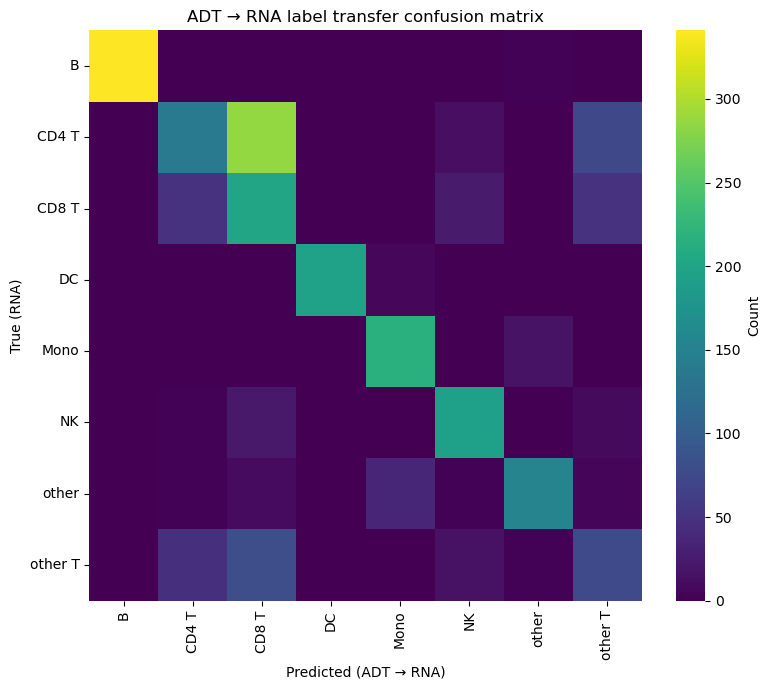

/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/

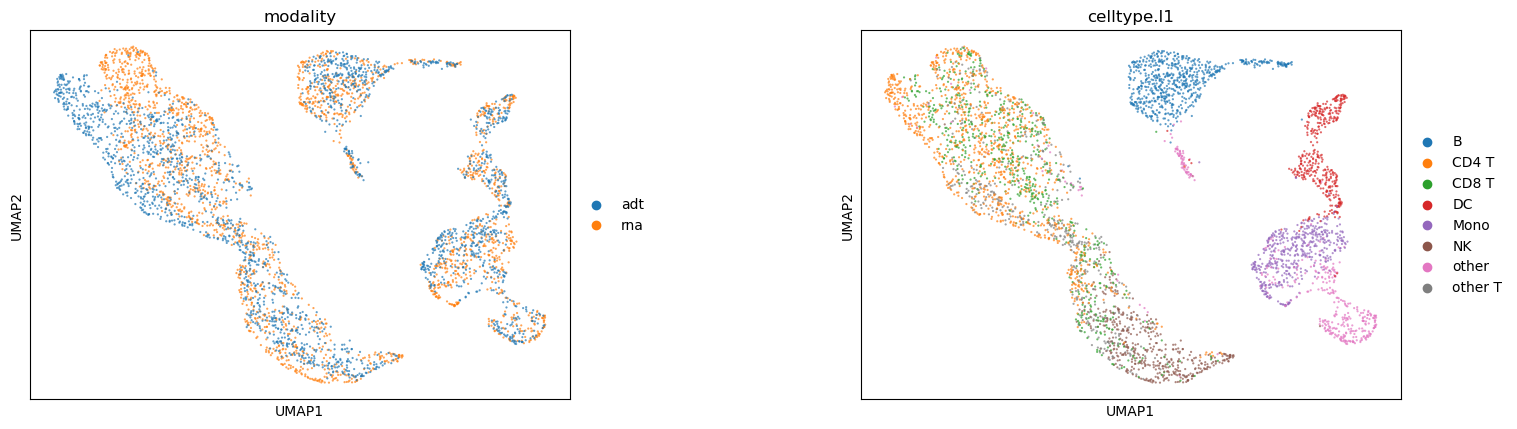

Mean ADT MSE (RNA→ADT): 16713.5303
Mean ADT Pearson r (RNA→ADT): 0.034


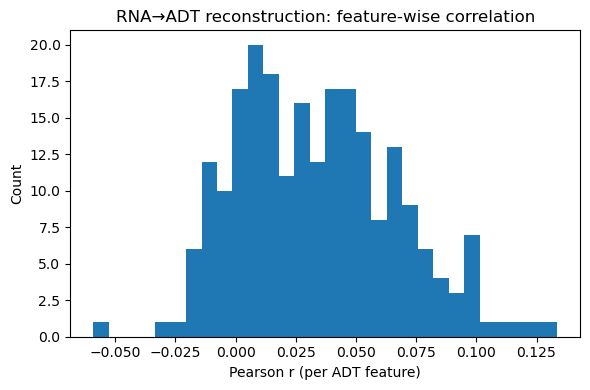

In [49]:
import numpy as np
import torch
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from univi import evaluation as univi_eval
# from univi import plotting as univi_plot  # optional, but not required for showing

# -------------------------
# 1. Encode latent embeddings
# -------------------------
z_rna = trainer.encode_modality(rna_test_adata, modality="rna")
z_adt = trainer.encode_modality(adt_test_adata, modality="adt")

rna_test_adata.obsm["X_univi"] = z_rna
adt_test_adata.obsm["X_univi"] = z_adt

# -------------------------
# 2. FOSCTTM (global alignment)
# -------------------------
foscttm = univi_eval.compute_foscttm(z_rna, z_adt)
print(f"FOSCTTM (rna vs adt): {foscttm:.4f}")

# -------------------------
# 3. Modality mixing in joint embedding
# -------------------------
Z_joint = np.concatenate([z_rna, z_adt], axis=0)
modality_labels = np.array(
    ["rna"] * z_rna.shape[0] + ["adt"] * z_adt.shape[0]
)

mixing_score = univi_eval.compute_modality_mixing(
    Z_joint,
    modality_labels,
    k=20,
)
print(f"Modality mixing score (k=20): {mixing_score:.3f}")

# -------------------------
# 4. Label transfer (ADT → RNA)
# -------------------------
labels_rna = rna_test_adata.obs["celltype.l1"].astype(str).values
labels_adt = adt_test_adata.obs["celltype.l1"].astype(str).values

pred_rna_from_adt, acc_rna, cm_rna = univi_eval.label_transfer_knn(
    Z_source=z_adt,
    labels_source=labels_adt,
    Z_target=z_rna,
    labels_target=labels_rna,
    k=15,
)

print(f"Label transfer accuracy (ADT → RNA, k=15): {acc_rna:.3f}")

# -------------------------
# 4a. Confusion matrix plot (show)
# -------------------------
uniq_labels = np.unique(labels_rna)

plt.figure(figsize=(8, 7))
sns.heatmap(
    cm_rna,
    annot=False,
    cmap="viridis",
    xticklabels=uniq_labels,
    yticklabels=uniq_labels,
    cbar_kws={"label": "Count"},
)
plt.xlabel("Predicted (ADT → RNA)")
plt.ylabel("True (RNA)")
plt.title("ADT → RNA label transfer confusion matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# If you still want a saved PNG version:
# from univi import plotting as univi_plot
# univi_plot.plot_confusion_matrix(
#     cm_rna,
#     labels=uniq_labels,
#     title="ADT → RNA label transfer",
#     savepath="../figures/citeseq_univi_label_transfer_cm_bipartite_training_l2_celltype_1k_cap.png",
# )

# -------------------------
# 5. UMAP visualization on UniVI latent
# -------------------------

# Make copies and add modality labels
rna_tmp = rna_test_adata.copy()
adt_tmp = adt_test_adata.copy()

rna_tmp.obs["modality"] = "rna"
adt_tmp.obs["modality"] = "adt"

# Concatenate for joint embedding
combined = rna_tmp.concatenate(
    adt_tmp,
    join="outer",
    batch_key="concat_batch",
    batch_categories=["rna", "adt"],
    index_unique=None,
)

# Ensure combined latent matches the stacked order
combined.obsm["X_univi"] = np.vstack([
    rna_test_adata.obsm["X_univi"],
    adt_test_adata.obsm["X_univi"],
])

# Compute neighbors/UMAP on UniVI space
sc.pp.neighbors(combined, use_rep="X_univi", n_neighbors=30)
sc.tl.umap(combined)

# Show UMAP colored by modality and celltype
sc.pl.umap(
    combined,
    color=["modality", "celltype.l1"],
    wspace=0.4,
    size=10,
    alpha=0.7,
    show=True,
)

# If you want to save as well:
# sc.pl.umap(
#     combined,
#     color=["modality", "celltype.l2"],
#     wspace=0.4,
#     size=10,
#     alpha=0.7,
#     save="_citeseq_univi_umap_bipartite_training_l2_celltype_1k_cap.png",
# )

# -------------------------
# 6. Cross-modal reconstruction metrics (RNA→ADT)
# -------------------------
model.eval()
with torch.no_grad():
    X_rna = rna_test_adata.X
    if sp.issparse(X_rna):
        X_rna = X_rna.toarray()
    X_rna_t = torch.as_tensor(X_rna, dtype=torch.float32, device=trainer.device)

    xhat_adt_list = []
    batch_size = 512
    for start in range(0, X_rna_t.shape[0], batch_size):
        xb = X_rna_t[start:start + batch_size]
        mu_dict, logvar_dict = model.encode_modalities({"rna": xb})
        mu_z, logvar_z = model.mixture_of_experts(mu_dict, logvar_dict)
        xhat_dict = model.decode_modalities(mu_z)
        xhat_adt_list.append(xhat_dict["adt"].cpu().numpy())

    xhat_adt = np.vstack(xhat_adt_list)

X_adt = adt_test_adata.X
if sp.issparse(X_adt):
    X_adt = X_adt.toarray()

mse_feat = univi_eval.mse_per_feature(X_adt, xhat_adt)
corr_feat = univi_eval.pearson_corr_per_feature(X_adt, xhat_adt)

print(f"Mean ADT MSE (RNA→ADT): {mse_feat.mean():.4f}")
print(f"Mean ADT Pearson r (RNA→ADT): {corr_feat.mean():.3f}")

# -------------------------
# 6a. Histogram of Pearson r (per ADT feature)
# -------------------------
plt.figure(figsize=(6, 4))
plt.hist(corr_feat, bins=30)
plt.xlabel("Pearson r (per ADT feature)")
plt.ylabel("Count")
plt.title("RNA→ADT reconstruction: feature-wise correlation")
plt.tight_layout()
plt.show()


FOSCTTM (rna vs adt): 0.4441
Modality mixing score (k=20): 0.249
Label transfer accuracy (ADT → RNA, k=15): 0.401


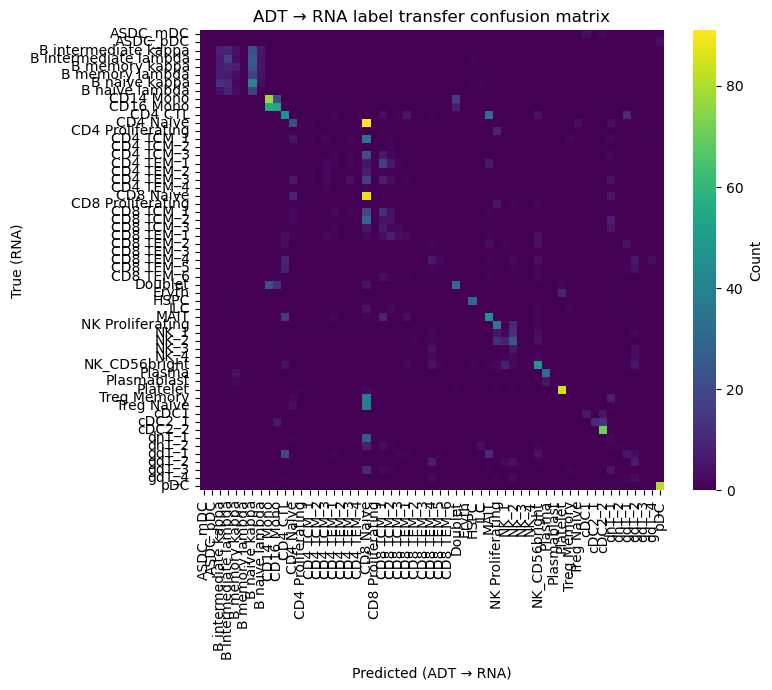

/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/

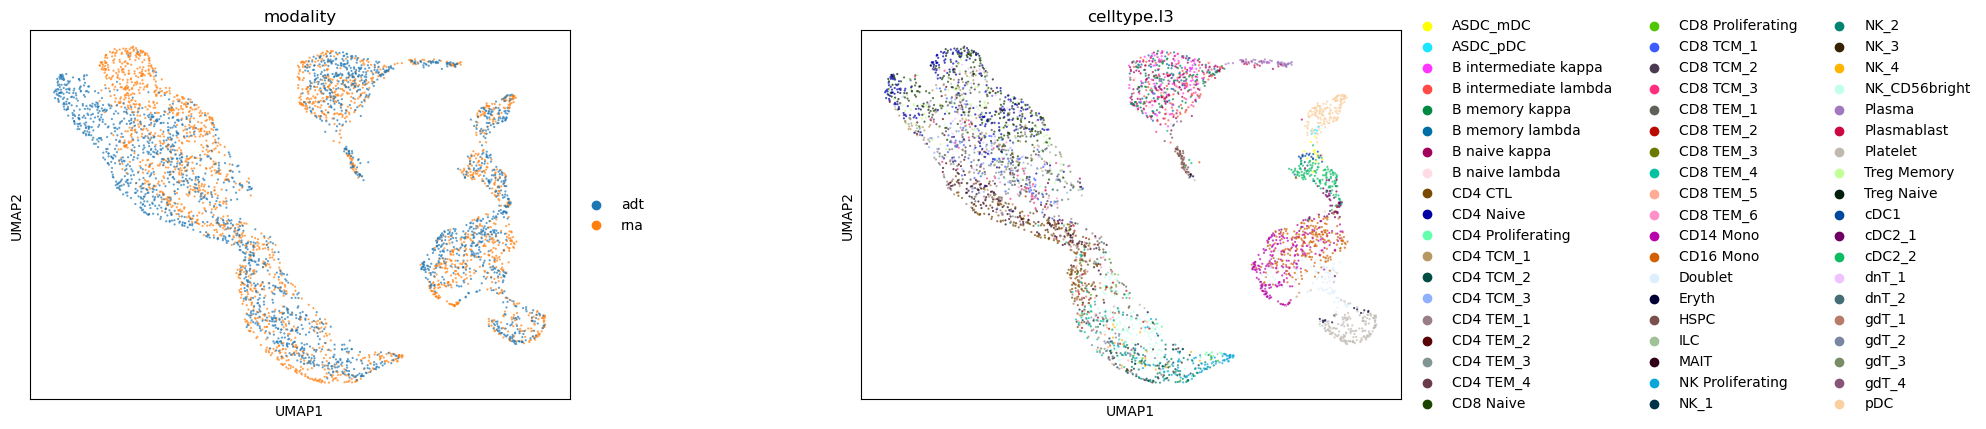

Mean ADT MSE (RNA→ADT): 16713.5303
Mean ADT Pearson r (RNA→ADT): 0.034


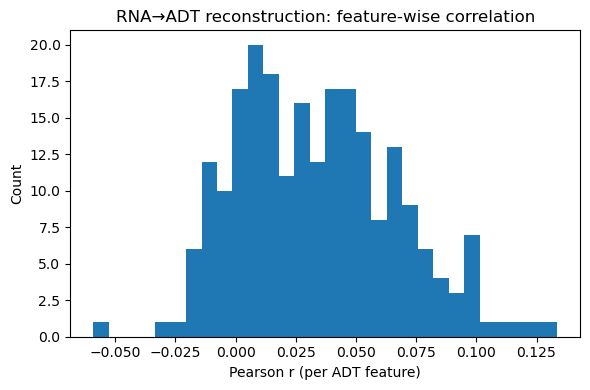

In [50]:
import numpy as np
import torch
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from univi import evaluation as univi_eval
# from univi import plotting as univi_plot  # optional, but not required for showing

# -------------------------
# 1. Encode latent embeddings
# -------------------------
z_rna = trainer.encode_modality(rna_test_adata, modality="rna")
z_adt = trainer.encode_modality(adt_test_adata, modality="adt")

rna_test_adata.obsm["X_univi"] = z_rna
adt_test_adata.obsm["X_univi"] = z_adt

# -------------------------
# 2. FOSCTTM (global alignment)
# -------------------------
foscttm = univi_eval.compute_foscttm(z_rna, z_adt)
print(f"FOSCTTM (rna vs adt): {foscttm:.4f}")

# -------------------------
# 3. Modality mixing in joint embedding
# -------------------------
Z_joint = np.concatenate([z_rna, z_adt], axis=0)
modality_labels = np.array(
    ["rna"] * z_rna.shape[0] + ["adt"] * z_adt.shape[0]
)

mixing_score = univi_eval.compute_modality_mixing(
    Z_joint,
    modality_labels,
    k=20,
)
print(f"Modality mixing score (k=20): {mixing_score:.3f}")

# -------------------------
# 4. Label transfer (ADT → RNA)
# -------------------------
labels_rna = rna_test_adata.obs["celltype.l3"].astype(str).values
labels_adt = adt_test_adata.obs["celltype.l3"].astype(str).values

pred_rna_from_adt, acc_rna, cm_rna = univi_eval.label_transfer_knn(
    Z_source=z_adt,
    labels_source=labels_adt,
    Z_target=z_rna,
    labels_target=labels_rna,
    k=15,
)

print(f"Label transfer accuracy (ADT → RNA, k=15): {acc_rna:.3f}")

# -------------------------
# 4a. Confusion matrix plot (show)
# -------------------------
uniq_labels = np.unique(labels_rna)

plt.figure(figsize=(8, 7))
sns.heatmap(
    cm_rna,
    annot=False,
    cmap="viridis",
    xticklabels=uniq_labels,
    yticklabels=uniq_labels,
    cbar_kws={"label": "Count"},
)
plt.xlabel("Predicted (ADT → RNA)")
plt.ylabel("True (RNA)")
plt.title("ADT → RNA label transfer confusion matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# If you still want a saved PNG version:
# from univi import plotting as univi_plot
# univi_plot.plot_confusion_matrix(
#     cm_rna,
#     labels=uniq_labels,
#     title="ADT → RNA label transfer",
#     savepath="../figures/citeseq_univi_label_transfer_cm_bipartite_training_l2_celltype_1k_cap.png",
# )

# -------------------------
# 5. UMAP visualization on UniVI latent
# -------------------------

# Make copies and add modality labels
rna_tmp = rna_test_adata.copy()
adt_tmp = adt_test_adata.copy()

rna_tmp.obs["modality"] = "rna"
adt_tmp.obs["modality"] = "adt"

# Concatenate for joint embedding
combined = rna_tmp.concatenate(
    adt_tmp,
    join="outer",
    batch_key="concat_batch",
    batch_categories=["rna", "adt"],
    index_unique=None,
)

# Ensure combined latent matches the stacked order
combined.obsm["X_univi"] = np.vstack([
    rna_test_adata.obsm["X_univi"],
    adt_test_adata.obsm["X_univi"],
])

# Compute neighbors/UMAP on UniVI space
sc.pp.neighbors(combined, use_rep="X_univi", n_neighbors=30)
sc.tl.umap(combined)

# Show UMAP colored by modality and celltype
sc.pl.umap(
    combined,
    color=["modality", "celltype.l3"],
    wspace=0.4,
    size=10,
    alpha=0.7,
    show=True,
)

# If you want to save as well:
# sc.pl.umap(
#     combined,
#     color=["modality", "celltype.l2"],
#     wspace=0.4,
#     size=10,
#     alpha=0.7,
#     save="_citeseq_univi_umap_bipartite_training_l2_celltype_1k_cap.png",
# )

# -------------------------
# 6. Cross-modal reconstruction metrics (RNA→ADT)
# -------------------------
model.eval()
with torch.no_grad():
    X_rna = rna_test_adata.X
    if sp.issparse(X_rna):
        X_rna = X_rna.toarray()
    X_rna_t = torch.as_tensor(X_rna, dtype=torch.float32, device=trainer.device)

    xhat_adt_list = []
    batch_size = 512
    for start in range(0, X_rna_t.shape[0], batch_size):
        xb = X_rna_t[start:start + batch_size]
        mu_dict, logvar_dict = model.encode_modalities({"rna": xb})
        mu_z, logvar_z = model.mixture_of_experts(mu_dict, logvar_dict)
        xhat_dict = model.decode_modalities(mu_z)
        xhat_adt_list.append(xhat_dict["adt"].cpu().numpy())

    xhat_adt = np.vstack(xhat_adt_list)

X_adt = adt_test_adata.X
if sp.issparse(X_adt):
    X_adt = X_adt.toarray()

mse_feat = univi_eval.mse_per_feature(X_adt, xhat_adt)
corr_feat = univi_eval.pearson_corr_per_feature(X_adt, xhat_adt)

print(f"Mean ADT MSE (RNA→ADT): {mse_feat.mean():.4f}")
print(f"Mean ADT Pearson r (RNA→ADT): {corr_feat.mean():.3f}")

# -------------------------
# 6a. Histogram of Pearson r (per ADT feature)
# -------------------------
plt.figure(figsize=(6, 4))
plt.hist(corr_feat, bins=30)
plt.xlabel("Pearson r (per ADT feature)")
plt.ylabel("Count")
plt.title("RNA→ADT reconstruction: feature-wise correlation")
plt.tight_layout()
plt.show()


In [35]:
print(history)


{'train_loss': [3063.847685478103, 1607.690861231844, 1554.9858535981514, 1521.1963612731074, 1487.1382609622578, 1470.0367242517605, 1464.7150844520247, 1461.612763740647, 1460.8304065113336, 1460.6554041043134, 1462.6732452822403, 1463.3273667886224, 1465.2790080325703, 1466.4503242600133, 1467.9433937610036, 1471.373134559309, 1473.4555337395466, 1476.3083753988776, 1478.6146773217429, 1480.9247599856953, 1484.5289409798636, 1486.4693328427597, 1489.7166816818883, 1491.4811392770687, 1494.2693197760784, 1492.7978395273988, 1490.7721222353653, 1490.6724251760563, 1490.182137502751, 1488.4016233632262], 'val_loss': [1625.348605685764, 1551.4630398220486, 1522.9082709418403, 1489.7572157118057, 1467.4280327690972, 1459.5931803385417, 1457.8945448133682, 1458.715087890625, 1461.741183810764, 1457.8354085286458, 1460.014675564236, 1460.1324462890625, 1461.1707899305557, 1463.1374104817708, 1466.2238905164932, 1472.298800998264, 1473.8770073784722, 1474.7193196614583, 1477.1745062934028, 

In [36]:
# Encode new cells to latent embeddings
z_rna = univi_eval.encode_adata(model, rna_unused, modality="rna", device=train_cfg.device)
z_adt = univi_eval.encode_adata(model, adt_unused, modality="adt", device=train_cfg.device)

rna_unused.obsm["X_univi"] = z_rna
adt_unused.obsm["X_univi"] = z_adt


In [37]:
# Cross modal generation from one modality to another: RNA -> ADT example
Xhat_adt_from_rna = univi_eval.cross_modal_predict(
    model,
    adata_src=rna_unused,
    src_mod="rna",
    tgt_mod="adt",
    device=train_cfg.device,
)


In [38]:
# Denoising using the decoders
univi_eval.denoise_adata(model, rna_unused, modality="rna", device=train_cfg.device)
univi_eval.denoise_adata(model, adt_unused, modality="adt", device=train_cfg.device)

# you now have rna_test_adata.layers["univi_denoised"] etc.


AnnData object with n_obs × n_vars = 139115 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'univi_split'
    var: 'features'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap', 'X_shared', 'X_univi'
    varm: 'APCA'
    layers: 'log1p', 'univi_denoised'

In [39]:
'''
celltype.l2
CD14 Mono            42690
CD4 Naive            17479
NK                   17173
CD4 TCM              14889
CD8 TEM              11727
CD8 Naive            10768
B naive               7718
CD16 Mono             6320
CD4 TEM               4282
gdT                   3649
B memory              3285
CD8 TCM               2883
MAIT                  2784
Treg                  2507
cDC2                  2501
B intermediate        2431
Platelet              2293
CD4 CTL               1736
NK_CD56bright          943
pDC                    861
Doublet                605
NK Proliferating       548
Plasmablast            366
dnT                    356
HSPC                   329
cDC1                   151
ILC                    132
CD4 Proliferating      108
CD8 Proliferating       91
Eryth                   83
ASDC                    76
'''

'\ncelltype.l2\nCD14 Mono            42690\nCD4 Naive            17479\nNK                   17173\nCD4 TCM              14889\nCD8 TEM              11727\nCD8 Naive            10768\nB naive               7718\nCD16 Mono             6320\nCD4 TEM               4282\ngdT                   3649\nB memory              3285\nCD8 TCM               2883\nMAIT                  2784\nTreg                  2507\ncDC2                  2501\nB intermediate        2431\nPlatelet              2293\nCD4 CTL               1736\nNK_CD56bright          943\npDC                    861\nDoublet                605\nNK Proliferating       548\nPlasmablast            366\ndnT                    356\nHSPC                   329\ncDC1                   151\nILC                    132\nCD4 Proliferating      108\nCD8 Proliferating       91\nEryth                   83\nASDC                    76\n'

In [40]:
# Sanity check total l2 celltypes for the unused RNA adata
print(rna_unused)
print(set(rna_unused.obs['celltype.l2']))
print(rna_unused.obs['celltype.l2'].value_counts())


AnnData object with n_obs × n_vars = 139115 × 2000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'univi_split'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap', 'X_shared', 'X_univi'
    varm: 'PCs', 'SPCA'
    layers: 'log1p', 'univi_denoised'
    obsp: 'distances'
{'NK', 'CD8 TEM', 'CD4 TCM', 'B naive', 'gdT', 'Treg', 'MAIT', 'CD4 TEM', 'CD4 Naive', 'cDC2', 'CD16 Mono', 'CD4 CTL', 'Platelet', 'B intermediate', 'CD8 TCM', 'B memory', 'CD14 Mono', 'CD8 Naive'}
CD14 Mono         41690
CD4 Naive         16479
NK                16173
CD4 TCM           13889
CD8 TEM           10727
CD8 Naive          9768
B naive            6718
CD16 Mono          5320
CD4 TEM            3282
gdT                2649
B memory      

In [41]:
# Sanity check total l2 celltypes for the unused ADT adata - should be the same as RNA adata above..
print(adt_unused)
print(set(adt_unused.obs['celltype.l2']))
print(adt_unused.obs['celltype.l2'].value_counts())


AnnData object with n_obs × n_vars = 139115 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'univi_split'
    var: 'features'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap', 'X_shared', 'X_univi'
    varm: 'APCA'
    layers: 'log1p', 'univi_denoised'
{'NK', 'CD8 TEM', 'CD4 TCM', 'B naive', 'gdT', 'Treg', 'MAIT', 'CD4 TEM', 'CD4 Naive', 'cDC2', 'CD16 Mono', 'CD4 CTL', 'Platelet', 'B intermediate', 'CD8 TCM', 'B memory', 'CD14 Mono', 'CD8 Naive'}
CD14 Mono         41690
CD4 Naive         16479
NK                16173
CD4 TCM           13889
CD8 TEM           10727
CD8 Naive          9768
B naive            6718
CD16 Mono          5320
CD4 TEM            3282
gdT                2649
B memory           2285
CD8 TCM            1883
MAIT               1784
Treg               1507
cDC2               1501
B intermediate 

In [42]:
# Sampling from the latent space per cell type

# fit per-celltype Gaussians in latent space
labels_rna = rna_unused.obs["celltype.l2"].astype(str).values
Z_rna = rna_unused.obsm["X_univi"]  # from encode_adata earlier

gauss_by_ct = univi_eval.fit_latent_gaussians_by_label(Z_rna, labels_rna)

# define how many samples per cell type
spec = {
    'CD14 Mono': 1000,
    'CD4 Naive': 1000,
    'NK': 1000,
    'CD4 TCM': 1000,
    'CD8 TEM': 1000,
    'CD8 Naive': 1000,
    'B naive': 1000,
    'CD16 Mono': 1000,
    'CD4 TEM': 1000,
    'gdT': 1000,
    'B memory': 1000,
    'CD8 TCM': 1000,
    'MAIT': 1000,
    'Treg': 1000,
    'cDC2': 1000,
    'B intermediate': 1000,
    'Platelet': 1000,
    'CD4 CTL': 1000,
    'NK_CD56bright': 1000,
    'pDC': 1000,
    'Doublet': 1000,
    'NK Proliferating': 1000,
    'Plasmablast': 1000,
    'dnT': 1000,
    'HSPC': 1000,
    'cDC1': 1000,
    'ILC': 1000,
    'CD4 Proliferating': 1000,
    'CD8 Proliferating': 1000,
    'Eryth': 1000,
    'ASDC': 1000,
}

z_samp_by_ct = univi_eval.sample_from_latent_gaussians(gauss_by_ct, spec, random_state=42)

# decode to desired modality
def decode_latent_samples(model, z_samp_by_ct, modality: str, device: str = "cpu"):
    model.eval()
    out = {}
    with torch.no_grad():
        for lab, Z in z_samp_by_ct.items():
            z_t = torch.as_tensor(Z, dtype=torch.float32, device=device)
            xhat_dict = model.decode_modalities(z_t)
            out[lab] = xhat_dict[modality].cpu().numpy()
    return out

synthetic_adt_by_ct = decode_latent_samples(model, z_samp_by_ct, modality="adt", device=train_cfg.device)


In [43]:
print(synthetic_adt_by_ct)


{'CD14 Mono': array([[35.801426,  9.229747, 47.859596, ...,  8.656156, 14.772447,
        44.498787],
       [37.957733,  9.728974, 50.732235, ...,  9.144671, 15.632133,
        47.11854 ],
       [36.597824,  9.410606, 48.88057 , ...,  8.837616, 15.07584 ,
        45.432568],
       ...,
       [33.085888,  8.548579, 44.467815, ...,  7.937509, 13.645648,
        41.011196],
       [35.596546,  9.175467, 47.573605, ...,  8.605735, 14.67918 ,
        44.22142 ],
       [38.02037 ,  9.749211, 50.801025, ...,  9.16782 , 15.66229 ,
        47.2123  ]], dtype=float32), 'CD4 Naive': array([[2.0826385, 5.0901775, 6.679998 , ..., 4.291453 , 5.846439 ,
        5.7669864],
       [2.0526085, 4.9114933, 6.4925623, ..., 4.152892 , 5.61788  ,
        5.5617423],
       [2.1032224, 5.0337343, 6.6208053, ..., 4.243639 , 5.7682815,
        5.7152653],
       ...,
       [1.942675 , 4.794941 , 6.3709393, ..., 4.075748 , 5.4886503,
        5.372063 ],
       [2.1104472, 4.9729776, 6.562831 , ..., 4.1852

Total synthetic samples: 18000
Latent dim: 40


/tmp/ipykernel_3716803/3473571165.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(uniq_cts))


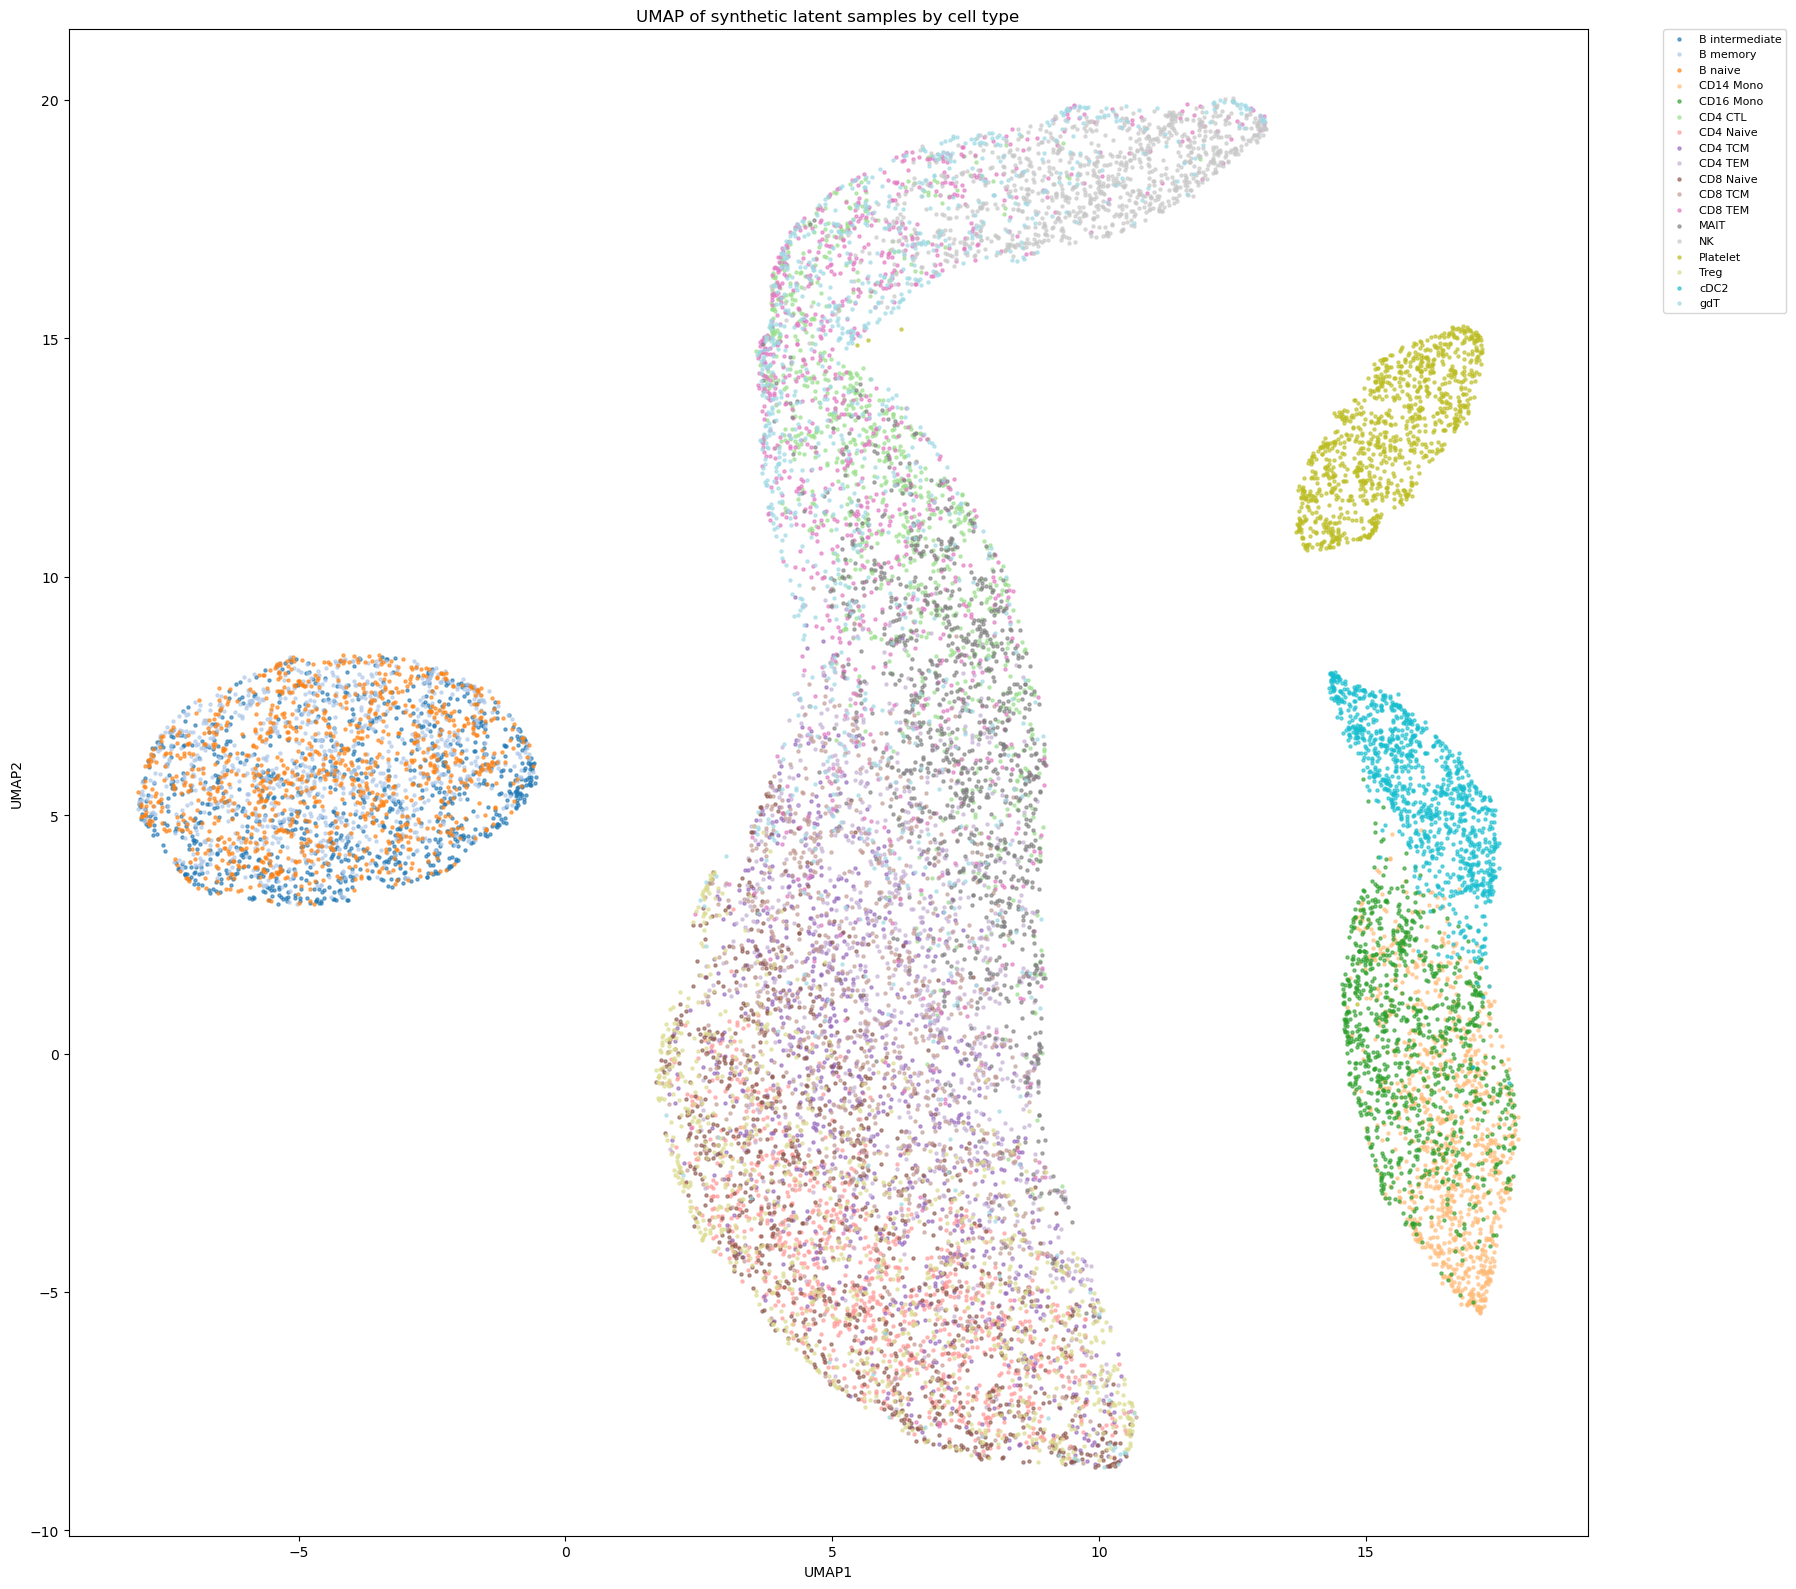

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# if not already installed:
# !pip install umap-learn
import umap

# -----------------------------
# Build matrix + labels from dict
# -----------------------------
# z_samp_by_ct: dict[celltype -> (n_samples, latent_dim)]
X_list = []
y_list = []

for ct, Z in z_samp_by_ct.items():
    X_list.append(Z)
    y_list.extend([ct] * Z.shape[0])

X = np.vstack(X_list)               # (N_total, latent_dim)
y = np.array(y_list, dtype=str)     # (N_total,)

print("Total synthetic samples:", X.shape[0])
print("Latent dim:", X.shape[1])

# -----------------------------
# UMAP embedding
# -----------------------------
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.3,
    metric="euclidean",
    random_state=42,
)
X_umap = reducer.fit_transform(X)   # (N_total, 2)

# -----------------------------
# Plot colored by cell type
# -----------------------------
plt.figure(figsize=(18, 16))

uniq_cts = np.unique(y)
# use a categorical colormap with enough colors
cmap = plt.cm.get_cmap("tab20", len(uniq_cts))

for i, ct in enumerate(uniq_cts):
    idx = (y == ct)
    plt.scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        s=5,
        alpha=0.6,
        color=cmap(i),
        label=ct,
    )

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of synthetic latent samples by cell type")
plt.legend(
    bbox_to_anchor=(1.05, 1.0),
    loc="upper left",
    borderaxespad=0.0,
    fontsize=8,
    ncol=1,
)
plt.tight_layout()
plt.show()


Total synthetic samples: 18000
Decoded dim: 228


/tmp/ipykernel_3716803/3620872675.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(uniq_cts))


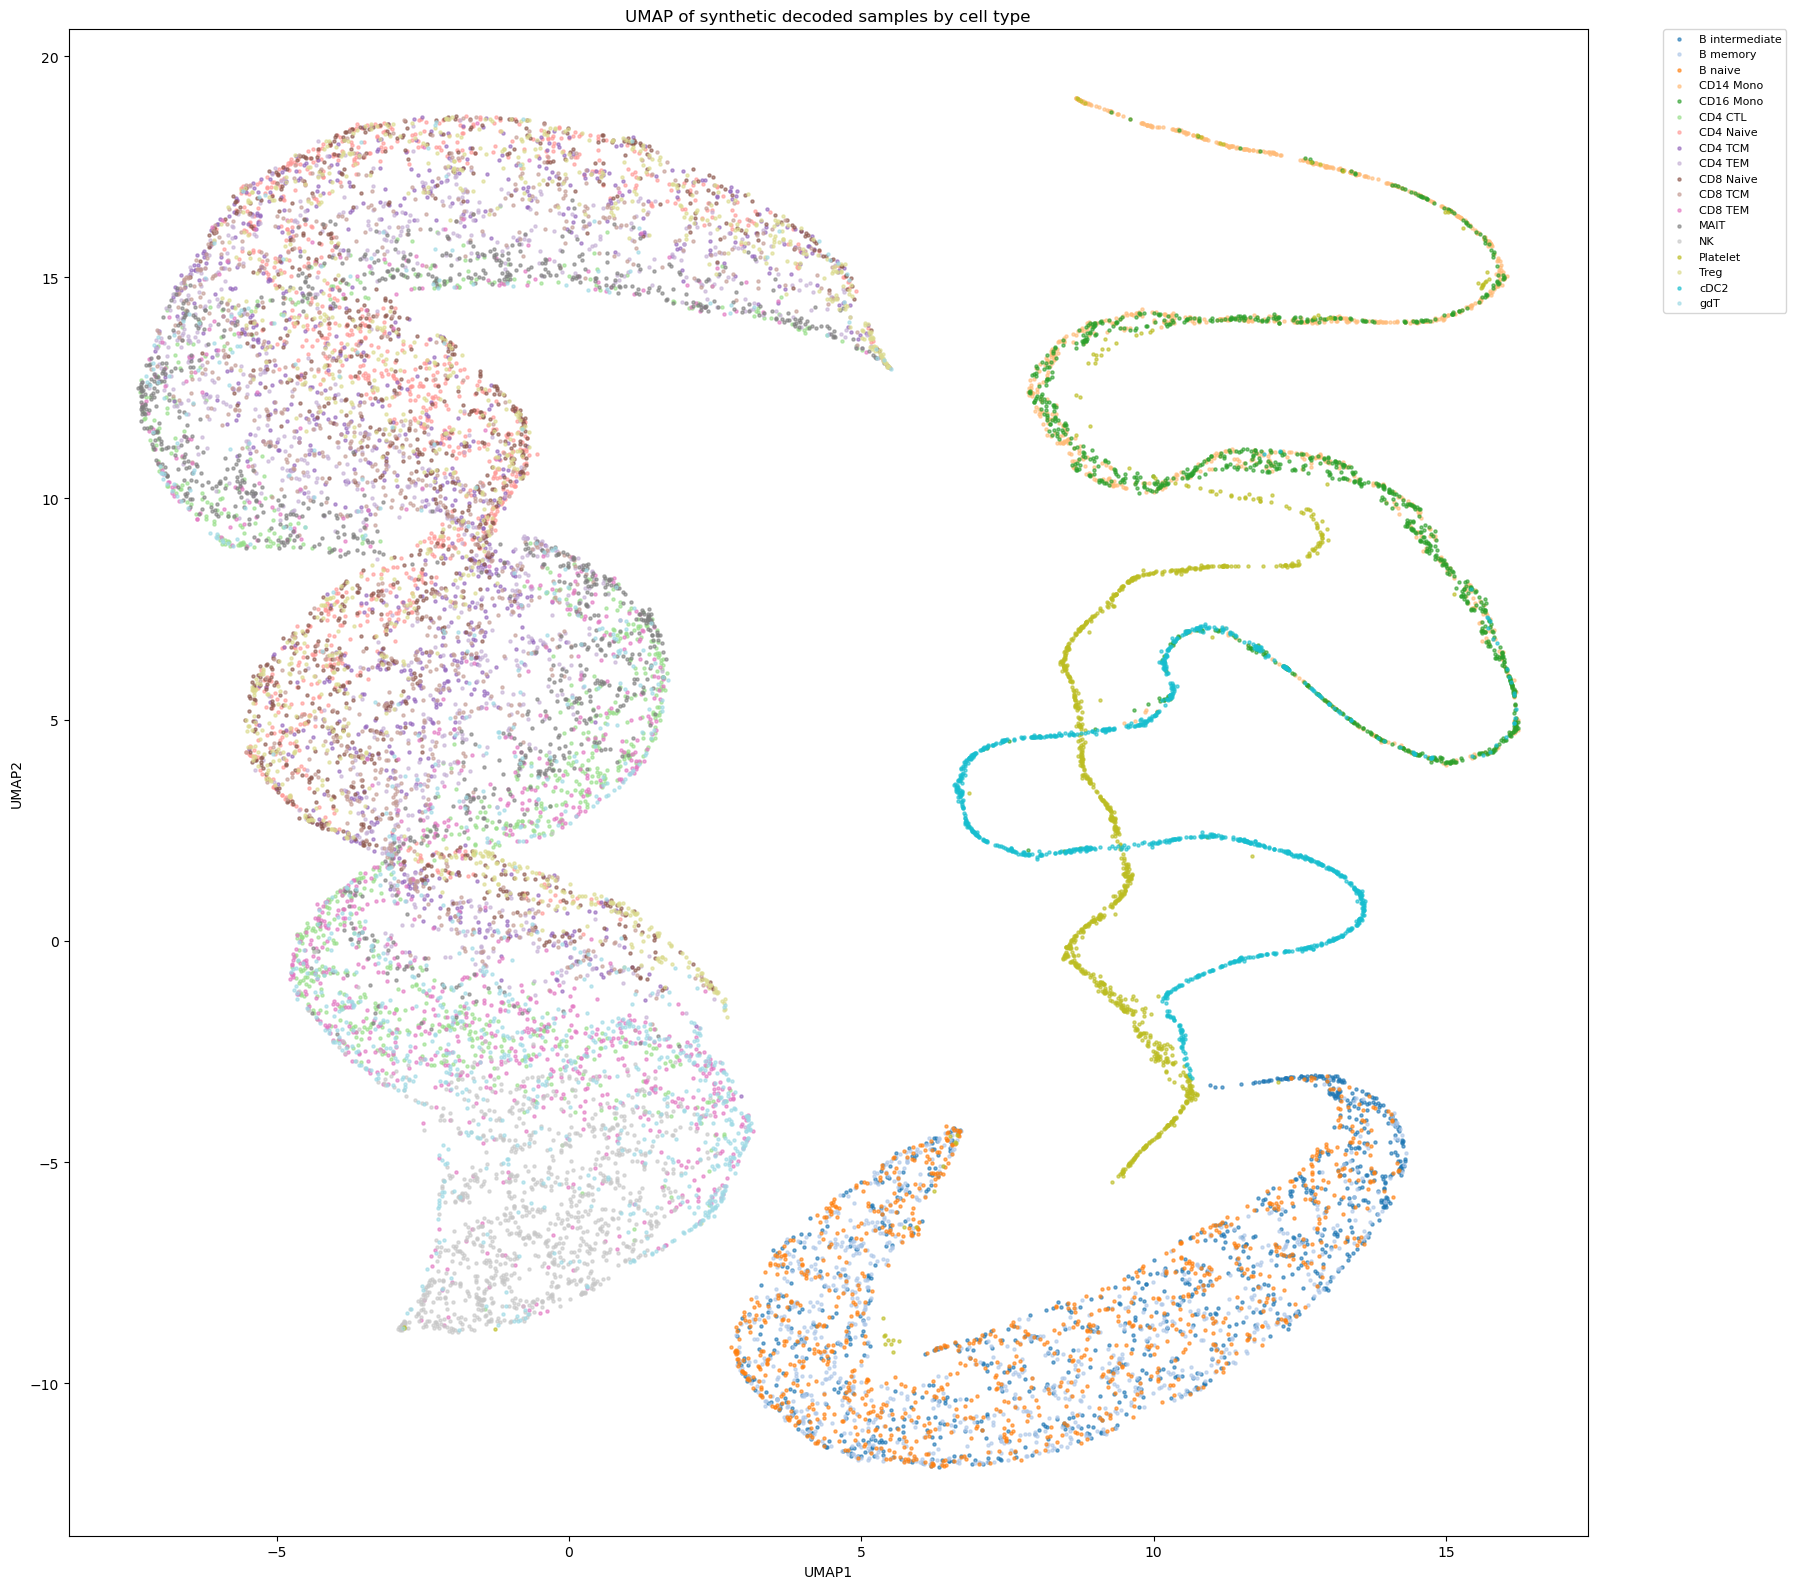

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# if not already installed:
# !pip install umap-learn
import umap

# -----------------------------
# Build matrix + labels from dict
# -----------------------------
# z_samp_by_ct: dict[celltype -> (n_samples, latent_dim)]
X_list = []
y_list = []

for ct, Z in synthetic_adt_by_ct.items():
    X_list.append(Z)
    y_list.extend([ct] * Z.shape[0])

X = np.vstack(X_list)               # (N_total, latent_dim)
y = np.array(y_list, dtype=str)     # (N_total,)

print("Total synthetic samples:", X.shape[0])
print("Decoded dim:", X.shape[1])

# -----------------------------
# UMAP embedding
# -----------------------------
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.3,
    metric="euclidean",
    random_state=42,
)
X_umap = reducer.fit_transform(X)   # (N_total, 2)

# -----------------------------
# Plot colored by cell type
# -----------------------------
plt.figure(figsize=(18, 16))

uniq_cts = np.unique(y)
# use a categorical colormap with enough colors
cmap = plt.cm.get_cmap("tab20", len(uniq_cts))

for i, ct in enumerate(uniq_cts):
    idx = (y == ct)
    plt.scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        s=5,
        alpha=0.6,
        color=cmap(i),
        label=ct,
    )

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of synthetic decoded samples by cell type")
plt.legend(
    bbox_to_anchor=(1.05, 1.0),
    loc="upper left",
    borderaxespad=0.0,
    fontsize=8,
    ncol=1,
)
plt.tight_layout()
plt.show()
